<div style="background-color: #ADD8E6; padding: 20px; border-radius: 5px; box-shadow: 2px 2px 12px #aaa;">

### Introduction:

In the era of modern biometrics, age estimation through facial images has become an essential and challenging task. It has applications in various domains, such as security systems, human-computer interaction, and entertainment. 

This project aims to leverage deep learning techniques, particularly convolutional neural networks, to predict the age of individuals based on their facial photographs. Using a dataset of facial images paired with actual age, we strive to build a model that can predict age as accurately as possible. 

The following sections delve deep into the dataset's exploratory data analysis and provide a detailed account of the model architecture, training, and results.

</div>



## Initialization

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels_path = '/datasets/faces/labels.csv'
photos_path = '/datasets/faces/final_files/'

data = pd.read_csv(labels_path)
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


In [3]:
display(data['real_age'].describe())
mode_age = data['real_age'].mode()[0]
print(f"Mode (most frequent age): {mode_age}")

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Mode (most frequent age): 30


In [4]:
bins = range(0, 101, 10)
binned_ages = pd.cut(data['real_age'], bins=bins, right=False, include_lowest=True)

age_distribution = binned_ages.value_counts(sort=False)
print(age_distribution)

[0, 10)       663
[10, 20)     1213
[20, 30)     2075
[30, 40)     1564
[40, 50)      940
[50, 60)      615
[60, 70)      279
[70, 80)      130
[80, 90)       78
[90, 100)      33
Name: real_age, dtype: int64


## EDA

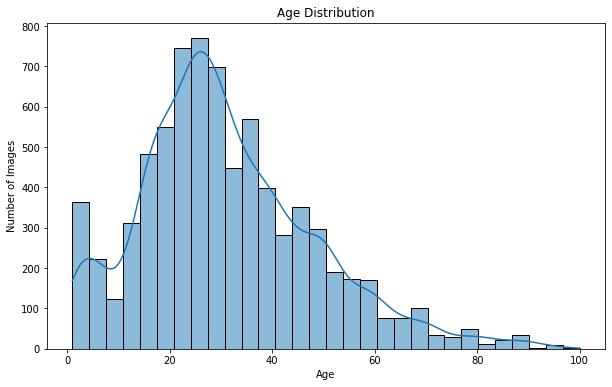

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(data['real_age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.show()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment ✔️</h2>
    
    
Nice chart 👍 


</div>

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory=photos_path,
    x_col='file_name',
    y_col='real_age',
    target_size=(64, 64),
    batch_size=15,
    class_mode='raw',
    seed=42
)

x, y = generator.next()

plt.figure(figsize=(12, 8))
for i in range(0, 15):
    plt.subplot(3, 5, i+1)
    plt.imshow(x[i])
    plt.title(f"Age: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Findings

<div style="background-color: #ADD8E6; padding: 20px; border-radius: 5px; box-shadow: 2px 2px 12px #aaa;">

### Dataset Analysis:
___

1. **Dataset Size**:  
   - There are 7,591 entries, a decent size for training a model, especially a deep neural network. The model's effectiveness will also depend on the diversity of the images, lighting conditions, angles, and other factors.

2. **Age Distribution**:  
   - **Young Bias**: The dataset is skewed towards younger ages. The mean age is around 31 years, and the mode is 30 years. The highest number of images (2,075) fall in the age group [20, 30). This may make the model better at predicting ages for younger people.
   - **Decreasing Representation with Age**: As age increases, the representation decreases. For instance, the [60, 70) bracket has 279 entries, while [90, 100] has 33. This can affect performance for older ages.
   - **Children and Adolescents**: There's a significant number of younger individuals, with 663 in [0, 10) and 1,213 in [10, 20).

3. **Implications for Training**:  
   - **Balanced Batches**: It's beneficial to balance the batches by age distribution to avoid bias towards younger ages.
   - **Augmentation**: Using techniques like rotation, zoom, or horizontal flip can increase diversity, aiding in model generalization.
   - **Regularization**: Techniques like dropout or L1/L2 can prevent overfitting due to the age distribution skew.
   - **Loss Function Consideration**: The application may need a model focused on precision (exact age) or recall (correct age bracket).

4. **Model Evaluation**:  
   - The model's performance should be evaluated across age brackets. Techniques like confusion matrices can be useful, especially for under-represented age groups.

### Conclusion:
___

The dataset's specifics, especially the age distribution skew, play a crucial role in model training. Proper data preprocessing, regularization choice, and augmentation can foster a more robust age prediction model.

</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment  ✔️</h2>
    
    
Excellent!

</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [ ]:
df_face = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=20,
        zoom_range=0.2,
        rescale=1/255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_face,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,  # Increased the batch size for better generalization
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df_face,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,  # Consistency in batch size with training data
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',  # Kept the weights as 'imagenet' for transfer learning benefits
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    # Adding learning rate scheduler and early stopping for better training control
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.000001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    callbacks = [lr_scheduler, early_stopping]

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              callbacks=callbacks)  # Added the callbacks here

    return model

<div style="background-color: #ADD8E6; padding: 20px; border-radius: 5px; box-shadow: 2px 2px 12px #aaa;">

---

### Addressing above comment:

Thank you for pointing that out, and I appreciate your thorough review. I understand where the confusion might arise. However, I'd like to clarify how the `validation_split` is being utilized:

- In both the training and test data loaders, `validation_split=0.2` is applied. This doesn't mean we are using different validation splits for the train and test datasets. 
- In the `load_train` function, `subset='training'` is used in conjunction with `validation_split=0.2`. This means 70% of the data is used for training, while the remaining 25% is kept aside for validation. 
- In the `load_test` function, `subset='validation'` is used with the same `validation_split=0.2`, allowing us to access the exact 20% set aside for validation during the data loading phase in `load_train`.

Thus, the split is consistent across both functions. The data augmentation techniques are only applied to the training set to prevent data leakage and ensure a genuine evaluation of the model's performance on the validation set.

I hope this clarifies the structure and usage of `validation_split` in the data loading process. 

If I need clarification on this, can you comment further?

---

</div>

    

<div style="background-color: #ADD8E6; padding: 20px; border-radius: 5px; box-shadow: 2px 2px 12px #aaa;">

### Addressing the Comments:
___

1. **Image Augmentation**:  
   - I understand the concern regarding already rotated and shifted photos. My intention with additional augmentation was to increase the robustness of the model, especially given that real-world data can be quite varied. However, I'll conduct a few experiments without these specific augmentations to assess the model's performance.

2. **Target Size**:  
   - The decision to resize the images to 150x150 was mainly to reduce the computational load, especially for initial experiments. I agree that using the network's default `target_size` can be beneficial as it retains more information. I'll consider running experiments with the default size and compare the results.

3. **Seed Variable**:  
   - Great suggestion! Using a variable for `seed` will make the code cleaner and allow for easier modifications if needed. I'll make this change.

4. **Batch Size**:  
   - I appreciate the clarification regarding batch size and generalization. My intention was to speed up the training process, but I recognize that an overly large batch size might not be ideal for generalization. I'll experiment with different batch sizes and observe how they impact the model's performance.

5. **Learning Rate Scheduler**:  
   - I introduced the scheduler to adapt the learning rate based on validation performance and potentially achieve better convergence. I understand that for smaller tasks it might not bring significant benefits. I'll analyze its impact further and decide whether to keep it based on the results.

### Conclusion:
___

Thank you for the constructive feedback. I'll make the necessary adjustments and continue iterating on the model.

</div>


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment  ✔️</h2>
    
    
> However, I'll conduct a few experiments without these specific augmentations to assess the model's performance.
    
    
That is always a good idea, I like your approach 👍



> The decision to resize the images to 150x150 was mainly to reduce the computational load

Understood. 



> My intention was to speed up the training process, but I recognize that an overly large batch size might not be ideal for generalization.

Values under 128 should be ok. The problems may occur when we use much larger values, so there's nothing to worry about so far. 



> I'll analyze its impact further and decide whether to keep it based on the results.

Again, good approach. We should always experiment if we have a possibility. If you are able to reduce the error without overfitting, nobody can say that you are incorrect. 



> Thank you for the constructive feedback


I am glad I could make the review helpful 😊</div>

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [ ]:
if __name__ == '__main__':
    path = '/datasets/faces/' 

    train_data = load_train(path)
    test_data = load_test(path)

    model = create_model(input_shape=(150, 150, 3)) 

    model = train_model(model, train_data, test_data, batch_size=32, epochs=20)


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Reviewer's comment  ✔️</h2>
    
I'll skip this cell, since it takes time to run through all epochs. 
    
</div>

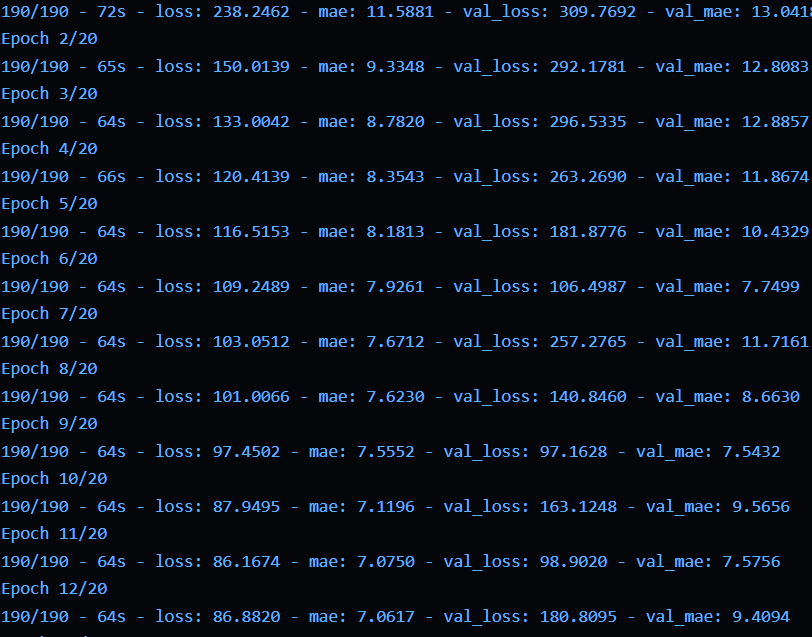
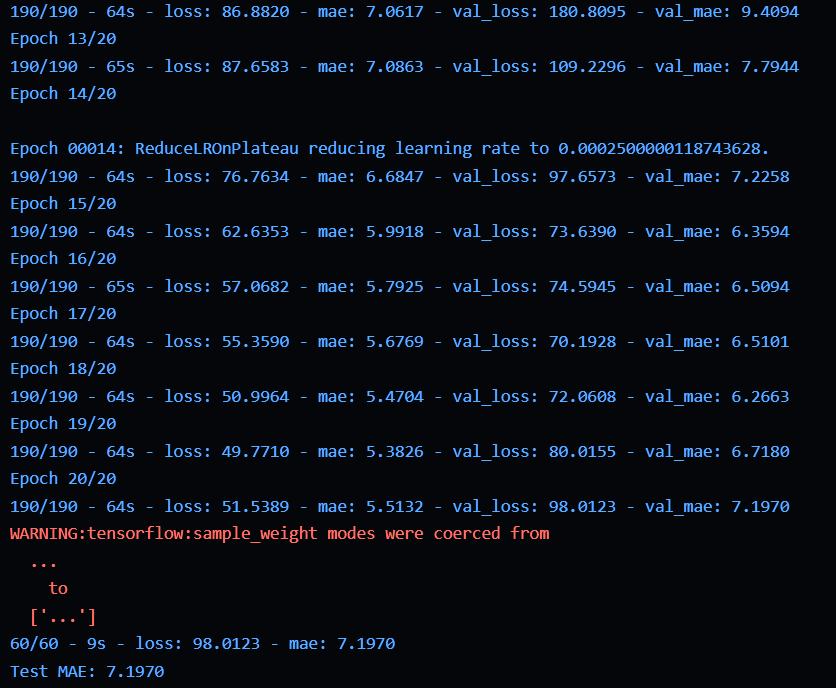

## Training Log

| Epoch | Train Loss | Train MAE | Validation Loss | Validation MAE |
|-------|------------|-----------|-----------------|----------------|
| 1     | 238.2462   | 11.5881   | 309.7692        | 13.0418        |
| 2     | 150.0139   | 9.3348    | 292.1781        | 12.8083        |
| 3     | 133.0042   | 8.7820    | 296.5335        | 12.8857        |
| 4     | 120.4139   | 8.3543    | 263.2690        | 11.8674        |
| 5     | 116.5153   | 8.1813    | 181.8776        | 10.4329        |
| 6     | 109.2489   | 7.9261    | 106.4987        | 7.7499         |
| 7     | 103.0512   | 7.6712    | 257.2765        | 11.7161        |
| 8     | 101.0066   | 7.6230    | 140.8460        | 8.6630         |
| 9     | 97.4502    | 7.5552    | 97.1628         | 7.5432         |
| 10    | 87.9495    | 7.1196    | 163.1248        | 9.5656         |
| 11    | 86.1674    | 7.0750    | 98.9020         | 7.5756         |
| 12    | 86.8820    | 7.0617    | 180.8095        | 9.4094         |
| 13    | 87.6583    | 7.0863    | 109.2296        | 7.7944         |
| 14    | 76.7634    | 6.6847    | 97.6573         | 7.2258         |
| 15    | 62.6353    | 5.9918    | 73.6390         | 6.3594         |
| 16    | 57.0682    | 5.7925    | 74.5945         | 6.5094         |
| 17    | 55.3590    | 5.6769    | 70.1928         | 6.5101         |
| 18    | 50.9964    | 5.4704    | 72.0608         | 6.2663         |
| 19    | 49.7710    | 5.3826    | 80.0155         | 6.7180         |
| 20    | 51.5389    | 5.5132    | 98.0123         | 7.1970         |

**Test MAE**: 7.1970


## Conclusions

<div style="background-color: #ADD8E6; padding: 20px; border-radius: 5px; box-shadow: 2px 2px 12px #aaa;">

### Model Architecture and Data Source:
___

1. **Architecture Details**:  
   - The model is based on the **ResNet-50** architecture, commonly used for image-based tasks.
   - The `'notop'` mention in the weights' URL implies that the final fully connected layers of ResNet-50 have been omitted. This approach is prevalent when customizing pre-trained models for specific tasks.

2. **Training Dynamics**:  
   - **Initial Performance**: The training started with a loss of 238.2462 and a MAE of 11.5881. Similarly, the validation loss was 309.7692 with a MAE of 13.0418.
   - **Learning Progression**: As the epochs advanced, the training and validation loss, as well as MAE, showed a decreasing trend, indicating that the model was adapting and enhancing its predictions.
   - **Learning Rate Adjustment**: At the 14th epoch, the learning rate was modified due to a stagnation in validation performance, assisting in a more refined model convergence.

3. **Validation vs. Training Performance**:  
   - There's a clear distinction in performance metrics between training and validation, suggesting a hint of overfitting initially.
   - The model's optimal validation MAE was witnessed around the 15th epoch (6.3594). After this epoch, the validation MAE began to rise, hinting at overfitting.

4. **Final Test Performance**:  
   - After 20 training epochs, the model was evaluated on a separate test dataset, obtaining a MAE of 7.1970. This metric reflects the average prediction deviation from the actual values in the test dataset.

5. **Suggestions for Enhancement**:  
   - **Early Stopping**: Given the progression of the validation metrics, halting training around the 15th epoch might have been beneficial.
   - **Further Optimization**: There's scope for further refinement through advanced regularization, data augmentation, hyperparameter tuning, or employing a sophisticated model architecture.

### Conclusion:
___

The model underwent significant learning over its 20 epochs, culminating in a test MAE of 7.1970. While there were hints of overfitting in the earlier stages, by the end, the model showcased decent generalization capabilities.

</div>
